In [2]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import torch
import torchvision
from torchvision import transforms, datasets

from torchvision.models.detection import *
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

import albumentations as A
# from engine import train_one_epoch, evaluate
# import utils
# import transforms as T

# # For image augmentations
# import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# # As the data directory contains .xml files
# from xml.etree import ElementTree as et
IMAGE_SIZE = 250

import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00


In [4]:
from datasets import load_dataset

dataset = load_dataset("mllab/alfafood")

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3346 [00:00<?, ? examples/s]

In [5]:
original_shape = dataset['train'][0]['image'].size
original_shape

(4000, 3000)

In [6]:
data_len = dataset.num_rows['train']
data_len

3346

In [7]:
type(dataset['train'][0]['image'].resize((IMAGE_SIZE, IMAGE_SIZE)))

PIL.Image.Image

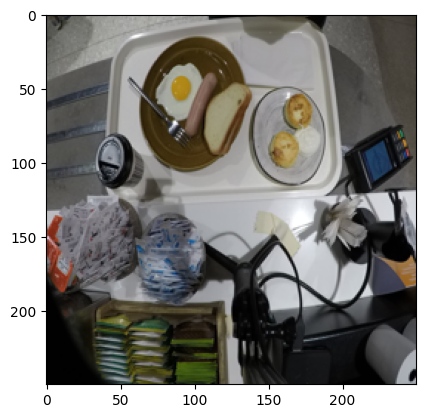

In [48]:
# cv2.imread(dataset['train'][2]['image'])
# plt.imshow(dataset['train'][2]['image'])
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

images = []

for i in range(300):
    images.append(dataset['train'][i]['image'].resize((IMAGE_SIZE, IMAGE_SIZE)))

# print(images.tobytes().__sizeof__() / 1024)
plt.imshow(images[5])

In [38]:
images[201].size

(250, 250)

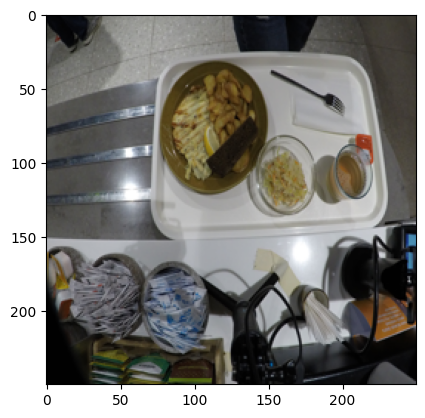

In [39]:
plt.imshow(images[201])

In [40]:
def scale_bbox(bbox):
    x_scale = IMAGE_SIZE / original_shape[0]
    y_scale = IMAGE_SIZE / original_shape[1]
    for i in bbox:
        i[0] *= x_scale
        i[2] *= x_scale
        i[1] *= y_scale
        i[3] *= y_scale
    return bbox

print(scale_bbox(dataset['train'][2]['objects']['bbox']))

[[82.8125, 25.295, 52.82, 61.28], [110.48, 36.269999999999996, 32.24125, 38.11], [9.413125, 1.8191666666666664, 147.941875, 128.65833333333333], [82.8125, 57.611666666666665, 51.219375, 65.85416666666666]]


In [94]:
images_bbox = []

for i in range(300):
    if len(dataset['train'][i]['objects']['bbox']) != 0:
        images_bbox.append(scale_bbox(dataset['train'][i]['objects']['bbox']))
    else:
        images_bbox.append(torch.zeros(0,4))

In [50]:
images_labels = []

for i in range(300):
    images_labels.append(dataset['train'][i]['objects']['categories'])

In [103]:
class AlfaFoodDataset(Dataset):
    def __init__(self, images, transform=True):
        # self.img_list = images
        # self.img_labels = list(i['categories'] for i in images_labels)

        # self.img_bbox = list(scale_bbox(i['bbox']) for i in images_labels)
        self.len_ = len(images)

        if transform is True:
            self.transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                #  transforms.RandomHorizontalFlip(p=0.5),
                                                #  transforms.RandomVerticalFlip(p=0.5),
                                                #  transforms.RandomCrop(size=(IMAGE_SIZE//2, IMAGE_SIZE)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                 ])
        else:
            self.transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                 transforms.ToTensor(),
                                                 #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                                 ])

    def __getitem__(self, index):
        # load image
        # cur_img = transforms.ToPILImage()(images[index]).convert('RGB')
        cur_img = images[index].convert('RGB')
        cur_img = self.transform(cur_img).permute(1, 2, 0)

        target = dict()
        res = []
        for i in images_bbox[index]:
            res.append([i[0], i[1], i[0] + i[2], i[1] + i[3]])
        # target['boxes'] = images_bbox[index]
        target['boxes'] = res
        target['labels'] = images_labels[index]

        return cur_img, target

    def __len__(self):
        return self.len_


In [13]:
def plot_img_bbox(img, bbox):

    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    ax.set_axis_off()
    ax.imshow(img)

    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", '#0099FF'] * 2
    for color, box in enumerate(bbox):
        # print(box)
        x, y, width, height  = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = colors[color],
                                 facecolor = 'none')
        # Draw the bounding box on top of the image
        ax.add_patch(rect)
    plt.show()

In [14]:
type(images[0])
# data = AlfaFoodDataset(images, transform=False)

# img, bbox = data[:100]
# plot_img_bbox(img[4], bbox[4])

PIL.Image.Image

In [87]:
def get_model(num_classes, modelName):

    # Loading the pre-trained model
    if modelName == 'fastrcnn':
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

    elif modelName == 'maskcnn':
        model = maskrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

In [104]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_split = 0.2

# Loading the training and the testing data with all tghe transformations
dataset_train = AlfaFoodDataset(images[:200], transform=True)
dataset_test = AlfaFoodDataset(images[200:300], transform=False)

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# # Train test split
# tsize = int(len(dataset) * test_split) # Getting the splitting index
# dataset_train = torch.utils.data.Subset(dataset_train, indices[:-tsize])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# Defining dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True,
                                              num_workers=4, collate_fn=collate_fn)  # Imported form helper library
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=True,
                                              num_workers=4, collate_fn=collate_fn)

In [107]:
dataset_train[52]

(tensor([[[-1.5528, -1.4755, -1.3164],
          [-1.5185, -1.4405, -1.2816],
          [-1.4672, -1.3880, -1.2293],
          ...,
          [-2.0665, -1.9832, -1.7522],
          [-2.0837, -2.0007, -1.7696],
          [-2.0665, -1.9832, -1.7522]],
 
         [[-1.4843, -1.4055, -1.2467],
          [-1.4843, -1.4055, -1.2467],
          [-1.4500, -1.3704, -1.2119],
          ...,
          [-2.0665, -1.9832, -1.7522],
          [-2.0665, -1.9832, -1.7522],
          [-2.0665, -1.9832, -1.7522]],
 
         [[-1.4329, -1.3529, -1.1944],
          [-1.4672, -1.3880, -1.2293],
          [-1.4500, -1.3704, -1.2119],
          ...,
          [-2.0837, -2.0007, -1.7696],
          [-2.0665, -1.9832, -1.7522],
          [-2.0837, -2.0007, -1.7696]],
 
         ...,
 
         [[-2.0837, -2.0007, -1.7696],
          [-2.1008, -2.0182, -1.7870],
          [-2.1008, -2.0182, -1.7870],
          ...,
          [-0.5082, -0.3200, -0.0441],
          [-0.6109, -0.4251, -0.1661],
          [-0.7822

In [108]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = get_model(num_classes=125, modelName='fastrcnn').to(device)

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [109]:
# targets = dict()
# targets['boxes'] = images_bbox
# targets['labels'] = images_labels
# [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
for i, data in enumerate(dataloader_train):
    image, targets = data[0], data[1]
    print(targets)

({'boxes': [[128.086875, 39.31916666666666, 157.58374999999998, 82.00166666666667], [80.754375, 66.45333333333333, 113.68125, 111.575], [30.22125, 52.42916666666666, 67.72125, 105.17249999999999], [14.6725, 2.1333333333333333, 166.273125, 129.86749999999998]], 'labels': [14, 15, 4, 99]}, {'boxes': [[168.559375, 0.0, 249.50437499999998, 95.41666666666666], [206.288125, 25.90416666666667, 235.55625, 74.685], [236.47125, 17.063333333333333, 250.0, 57.611666666666665], [199.656875, 0.0, 221.15062500000002, 8.831666666666667]], 'labels': [99, 43, 14, 46]}, {'boxes': [], 'labels': []}, {'boxes': [[85.588125, 62.85583333333333, 105.514375, 90.98666666666666], [70.1325, 108.625, 97.426875, 142.56083333333333], [35.23625, 91.2625, 61.609375, 130.51999999999998], [26.5275, 25.0, 185.208125, 152.315], [144.398125, 101.09583333333333, 174.78, 141.605], [156.261875, 39.9, 178.775, 83.19166666666666], [155.031875, 47.409166666666664, 181.265625, 89.4575], [152.52, 49.45583333333333, 175.125625, 91.3

In [110]:
import sys
import math

def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)

#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.permute(2, 1, 0).to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        # print(images[0].shape)
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step() #

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [1]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, dataloader_train, device, epoch)

NameError: name 'train_one_epoch' is not defined